In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt


In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.1
KerasNLP version: 0.17.0


In [4]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
nan_keyword_count = df_train['keyword'].isna().sum()
nan_location_count = df_train['location'].isna().sum()
print(nan_keyword_count, nan_location_count)

61 2533


In [8]:
df_process = df_train.copy()
label_encoder = LabelEncoder()
df_process['keyword_encoded'] = label_encoder.fit_transform(df_process['keyword'])
df_process['location_encoded'] = label_encoder.fit_transform(df_process['location'])
df_process

,id,keyword,location,text,target,keyword_encoded,location_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,221,3341
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,221,3341
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,221,3341
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,221,3341
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,221,3341
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,221,3341
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,221,3341
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,221,3341
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,221,3341


In [9]:
correlation_keyword = df_process['keyword_encoded'].corr(df_process['target'])
correlation_location = df_process['location_encoded'].corr(df_process['target'])
print(correlation_keyword)
print(correlation_location)

0.062169589169883646
-0.002955651807419477


In [10]:
X = df_process["text"]
y = df_process["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
preset = "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor,  num_classes=2)
classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
BATCH_SIZE = 32
EPOCHS = 2

In [13]:
from tensorflow import keras as kerass

In [14]:
classifier.compile(
    loss=kerass.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=kerass.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3947s 21s/step - accuracy: 0.7120 - loss: 0.5653 - val_accuracy: 0.8391 - val_loss: 0.3896
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3892s 20s/step - accuracy: 0.8455 - loss: 0.3770 - val_accuracy: 0.8404 - val_loss: 0.3853


In [15]:
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)

191/191 ━━━━━━━━━━━━━━━━━━━━ 1024s 5s/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step


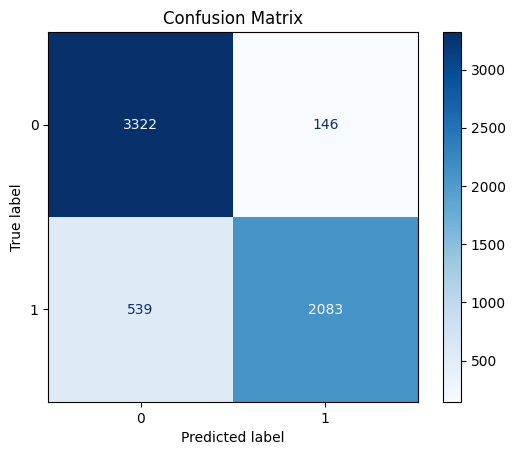

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, np.argmax(y_pred_train, axis=1)))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

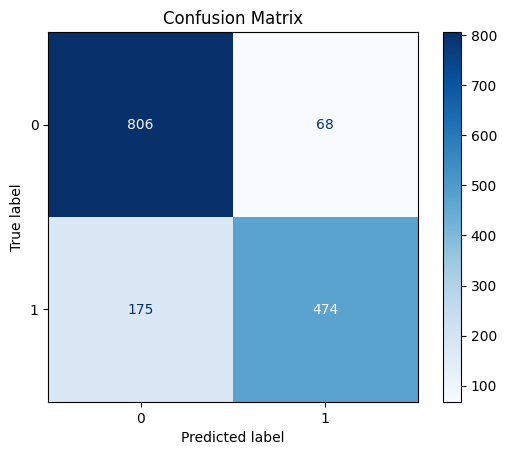

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, np.argmax(y_pred_val, axis=1)))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [18]:
output = df_test.copy()
output['target'] = np.argmax(classifier.predict(df_test['text']), axis=1)
output = output.drop(['keyword', 'location', 'text'], axis=1)
output.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 531s 5s/step


In [19]:
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
